## 3.6 Homework



The goal of this homework is to familiarize users with workflow orchestration. We start from the solution of homework 1. The notebook can be found below:

https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/01-intro/homework.ipynb

This has already been converted to a script called `homework.py` in the `03-orchestration` folder of this repo. 

You will use the FHV dataset like in homework 1.

## Motivation



We already have a model training script. Maybe a data scientist in your team handed it to you and your job is schedule the running of training script using a workflow orchestration - Prefect in this case. Below are the requirements. Do not implement them yet, we will do so in this exercise. Just understand the goal.

1. The training flow will be run every month.
2. The flow will take in a parameter called `date` which will be a datetime.
    * a. `date` should default to `None`.
    * b. If `date` is `None`, set `date` as the current day. Use the data from 2 months back as the training data and the data from the previous month as validation data.
    * c. If `date` is passed, get 2 months before the `date` as the training data, and the previous month as validation data.
    * d. As a concrete example, if the date passed is "2021-03-15", the training data should be "fhv_tripdata_2021-01.parquet" and the validation file will be "fhv_trip_data_2021-02.parquet".
3. Save the model as "model-{date}.bin" where date is in `YYYY-MM-DD`. Note that `date` here is the value of the flow `parameter`. In practice, this setup makes it very easy to get the latest model to run predictions because you just need to get the most recent one.
4. In this example we use a DictVectorizer. That is needed to run future data through our model. Save that as "dv-{date}.b". Similar to above, if the date is `2021-03-15`, the files output should be `model-2021-03-15.bin` and `dv-2021-03-15.b`.

This convention is not strict in industry, and in practice, you will come up with your own system to manage these training pipeline runs. For example, if we wanted to train on the whole history instead of just one month, we'd need to allow for added parameterization and logic in our flow. If the data came in weekly instead of monthly, we might need a different naming convention. But these requirements are already a simple approximation of something you could use in production.

On the deployment side, it's very easy to just pull in the latest data and predict it using the latest model and vectorizer files. Tools the MLFlow in the last chapter can simplify that process as well. This homework will focus more on the batch training.

In order, this homework assignment will be about:

1. Converting the script to a Flow.
2. Changing the parameters to take in a `date`. Making this parameter dynamic.
3. Scheduling a batch training job that outputs the latest model somewhere.


## Setup


You can use either local Prefect Orion or a VM hosted Prefect Orion instance for this. It shouldn't matter. Just note that if you use a VM hosted one, you will need to configure your local API to hit the VM.

Video 3.4 of the course will give more detailed instructions if you been run it on a VM.

## Q1. Converting the script to a Prefect flow



If you want to follow the videos exactly, do:

```bash
pip install prefect==2.0b5
```

If you need Windows support, check [`windows.md`](windows.md) for installation instructions.

The current script `homework.py` is a fully functional script as long as you already have `fhv_trip_data_2021-01.parquet` and `fhv_trip_data_2021-02.parquet` inside a `data` folder. You should be able to already run it using:

```bash
python homework.py
```

We want to bring this to workflow orchestration to add observability around it. The `main` function will be converted to a `flow` and the other functions will be `tasks`. After adding all of the decorators, there is actually one task that you will need to call `.result()` for inside the `flow` to get it to work. Which task is this?

* `read_data`
* `prepare_features`
* **train_model**
* `run_model`

Important: change all `print` statements to use the Prefect logger. Using the `print` statement will not appear in the Prefect UI. You have to call `get_run_logger` at the start of the task to use it.


Answers: **train_model**

From my own experience, if there is a tuple in main fuction, it need .result() to store the tuple.

## Q2. Parameterizing the flow



Right now there are two parameters for `main()` called `train_path` and `val_path`. We want to change the flow function to accept `date` instead. `date` should then be passed to a task that gives both the `train_path` and `val_path` to use.

It should look like this:

```python
@flow
def main(date=None):
    train_path, val_path = get_paths(date).result()
    # rest of flow below
```

Where `get_paths` is a task that you have to implement. The specs for this are outlined in the motivation section. Listing them out again here:

* a. The flow will take in a parameter called `date` which will be a datetime. `date` should default to `None`.
* b. If `date` is `None`, use the current day. Use the data from 2 months back as the training data and the data from the previous month as validation data.
* c. If a `date` value is supplied, get 2 months before the `date` as the training data, and the previous month as validation data.
* d. As a concrete example, if the date passed is "2021-03-15", the training data should be "fhv_tripdata_2021-01.parquet" and the validation file will be "fhv_trip_data_2021-02.parquet".

Because we have two files:

* fhv_tripdata_2021-01.parquet
* fhv_tripdata_2021-02.parquet

Change the `main()` flow call to the following:

```python
main(date="2021-03-15")
```

and it should use those files. This is a simplification for testing our homework.

Recall the page from where we downloaded the For-Hire trip data.

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Download the relevant files needed to run the `main` flow if `date` is 2021-08-15.

For example:

```python
main(date="2021-08-15")
```

By setting up the logger from the previous step, we should see some logs about our training job. What is the validation MSE when running the flow with this date?

Note you need to download the relevant files to run. Part of this question is understanding which files the flow should be looking for.

The validation **RMSE** is:

* **11.637**
* 11.837
* 12.037
* 12.237


**Notes**: Due to the FHV data at 2021 June and July cannot be downloaded, I used 2021 Jan and Feb data.

**Answer**: RMSE of validation data: 11.014

**Output**

```
09:38:04.241 | INFO    | prefect.engine - Created flow run 'quixotic-dolphin' for flow 'main'
09:38:04.241 | INFO    | Flow run 'quixotic-dolphin' - Using task runner 'ConcurrentTaskRunner'
09:38:04.558 | INFO    | Flow run 'quixotic-dolphin' - Created task run 'get_paths-6e696e34-0' for task 'get_paths'
09:38:05.322 | INFO    | Task run 'get_paths-6e696e34-0' - Finished in state Completed()
09:38:05.397 | INFO    | Flow run 'quixotic-dolphin' - Created task run 'read_dataframe-c80ba253-0' for task 'read_dataframe'
09:38:05.608 | INFO    | Flow run 'quixotic-dolphin' - Created task run 'read_dataframe-c80ba253-1' for task 'read_dataframe'
09:38:05.875 | INFO    | Flow run 'quixotic-dolphin' - Created task run 'preprocess_features-eacd9c4d-0' for task 'preprocess_features'
09:38:17.055 | INFO    | Flow run 'quixotic-dolphin' - Created task run 'preprocess_features-eacd9c4d-1' for task 'preprocess_features'
09:38:30.036 | INFO    | Task run 'read_dataframe-c80ba253-1' - Finished in state Completed()
09:38:36.469 | INFO    | Task run 'read_dataframe-c80ba253-0' - Finished in state Completed()
09:38:36.909 | INFO    | Task run 'preprocess_features-eacd9c4d-1' - The mean duration of validation is 20.707
09:38:38.155 | INFO    | Flow run 'quixotic-dolphin' - Created task run 'train_model-7c866860-0' for task 'train_model'
09:38:38.694 | INFO    | Task run 'preprocess_features-eacd9c4d-0' - The mean duration of training is 19.167
09:39:32.274 | INFO    | Task run 'preprocess_features-eacd9c4d-0' - Finished in state Completed()
09:39:42.154 | INFO    | Task run 'preprocess_features-eacd9c4d-1' - Finished in state Completed()
09:41:00.399 | INFO    | Task run 'train_model-7c866860-0' - X_train size: (1109826, 525)
09:41:00.406 | INFO    | Task run 'train_model-7c866860-0' - Dict Vectorizer has 525 features
09:41:00.408 | INFO    | Task run 'train_model-7c866860-0' - RMSE of training data: 10.529
09:41:01.189 | INFO    | Task run 'train_model-7c866860-0' - Finished in state Completed()
09:41:01.286 | INFO    | Flow run 'quixotic-dolphin' - Created task run 'run_model-6559300c-0' for task 'run_model'
09:41:32.790 | INFO    | Task run 'run_model-6559300c-0' - X_val size: (990113, 525)
09:41:32.797 | INFO    | Task run 'run_model-6559300c-0' - Dict Vectorizer has 525 features
09:41:32.805 | INFO    | Task run 'run_model-6559300c-0' - RMSE of validation data: 11.014
09:41:33.361 | INFO    | Task run 'run_model-6559300c-0' - Finished in state Completed()
09:42:20.962 | INFO    | Flow run 'quixotic-dolphin' - Finished in state Completed('All states completed.')
```

## Q3. Saving the model and artifacts

At the moment, we are not saving the model and vectorizer for future use. You don't need a new task for this, you can just add it inside the `flow`. The requirements for filenames to save it as were mentioned in the Motivation section. They are pasted again here:

* Save the model as "model-{date}.bin" where date is in `YYYY-MM-DD`. Note that `date` here is the value of the flow `parameter`. In practice, this setup makes it very easy to get the latest model to run predictions because you just need to get the most recent one.
* In this example we use a DictVectorizer. That is needed to run future data through our model. Save that as "dv-{date}.b". Similar to above, if the date is `2021-03-15`, the files output should be `model-2021-03-15.bin` and `dv-2021-03-15.b`.

By using this file name, during inference, we can just pull the latest model from our model directory and apply it. Assuming we already had a list of filenames:

```python
['model-2021-03-15.bin', 'model-2021-04-15.bin', 'model-2021-05-15.bin']
```

We could do something like `sorted(model_list, reverse=False)[0]` to get the filename of the latest file. This is the simplest way to consistently use the latest trained model for inference. Tools like MLFlow give us more control logic to use flows.

What is the file size of the `DictVectorizer` that we trained when the `date` is 2021-08-15?

* **13,000 bytes**
* 23,000 bytes 
* 33,000 bytes 
* 43,000 bytes 

You can bring up the Orion UI and see the work you've been doing. If you are using local Orion, you can start the server with:

```bash
prefect orion start
```

You should be able to see previous Flow runs and the most recent successful runs. Navigate to some of them. Take time to explore the UI. The radar plot would be a good thing to share on social media if you participate in those posts.

**Notes**: Due to the FHV data at 2021 June and July cannot be downloaded, I used 2021 Jan and Feb data.

**Answer**: 13,000 bytes

**Output**

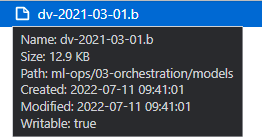

## Q4. Creating a deployment with a CronSchedule


We previously showed the `IntervalSchedule` in the video tutorials. In some cases, the interval is too rigid. For example, what if we wanted to run this `flow` on the 15th of every month? An interval of 30 days would not be in sync. In cases like these, the `CronSchedule` is more appropriate. The documentation for that is [here](https://orion-docs.prefect.io/concepts/schedules/#cronschedule)

Cron is an important part of workflow orchestration. It is used to schedule tasks, and was a predecessor for more mature orchestration frameworks. A lot of teams still use Cron in production. Even if you don't use Cron, the Cron expression is very common as a way to write a schedule, and the basics are worth learning for orchestration, even outside Prefect.

For this exercise, use a `CronSchedule` when creating a Prefect deployment.

What is the Cron expression to run a flow at 9 AM every 15th of the month?

* `* * 15 9 0`
* `9 15 * * *`
* **`0 9 15 * *`**
* `0 15 9 1 *`

Hint: there are many Cron to English tools. Try looking for one to help you.

Create a deployment with `prefect deployment create` after you write your `DeploymentSpec`

**Notes**: Due to the FHV data at 2021 June and July cannot be downloaded, I used 2021 Jan and Feb data.

**Answer**:  0 9 15 * *

## Q5. Viewing the Deployment 

View the deployment in the UI. When first loading, we may not see that many flows because the default filter is 1 day back and 1 day forward. Remove the filter for 1 day forward to see the scheduled runs. 

How many flow runs are scheduled by Prefect in advance? You should not be counting manually. There is a number of upcoming runs on the top right of the dashboard.

* 0
* **3**
* 10
* 25

**Note:** Your answer may be off by 1. It's okay. Select the option closest to your answer.

**Notes**: Due to the FHV data at 2021 June and July cannot be downloaded, I used 2021 Jan and Feb data.

**Answer**: Actually 4

## Q6. Creating a work-queue

In order to run this flow, you will need an agent and a work queue. Because we scheduled our flow on every month, it won't really get picked up by an agent. For this exercise, create a work-queue from the UI and view it using the CLI. 

For all CLI commands with Prefect, you can use `--help` to get more information. 

For example,

* `prefect --help`
* `prefect work-queue --help`

What is the command to view the available work-queues?

* `prefect work-queue inspect`
* **`prefect work-queue ls`**
* `prefect work-queue preview`
* `prefect work-queue list`

**Notes**: Due to the FHV data at 2021 June and July cannot be downloaded, I used 2021 Jan and Feb data.

**Answer**: 

```
$ prefect work-queue ls
                               Work Queues
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃                                   ID ┃ Name        ┃ Concurrency Limit ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 1fc86a16-e22f-4200-8421-9a6abfc5adf4 │ Global HW   │ None              │
│ 9d6c401b-2c61-4057-bf36-abc0692cce26 │ Global (**) │ None              │
└──────────────────────────────────────┴─────────────┴───────────────────┘
                       (**) denotes a paused queue
```